In [ ]:
# Download dataset from kaggle datasets download -d adityajn105/flickr8k and Extract Dataset

In [1]:
import timm
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1204cdb80>>
Traceback (most recent call last):
  File "/Users/abhijeetlokhande/.pyenv/versions/3.12.3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
/Users/abhijeetlokhande/.pyenv/versions/3.12.3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
MODEL_CHECKPOINT = "distilbert/distilbert-base-uncased"

#### Prepare Dataset

In [6]:
import pandas as pd
import albumentations as A
import cv2
from typing import List, Any

def get_image_transform():
    return A.Compose([
        A.Resize(224, 224, always_apply=True),
        A.Normalize(max_pixel_value=255.0, always_apply=True),
        ])    


class TextToImageSearchDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames: List[str], captions: List[str]) -> None:
        super().__init__()
        self.image_filenames = image_filenames
        self.captions = captions
        self.tokenizer = DistilBertTokenizer.from_pretrained(MODEL_CHECKPOINT)
        self.encoded_captions = self.tokenizer(
            self.captions, return_tensors="pt", truncation=True, is_split_into_words=False, max_length=30, padding=True)
        self.image_transforms = get_image_transform()

    def __getitem__(self, index):
        item = {key: torch.tensor(value[index]).clone().detach()
                for key, value in self.encoded_captions.items()}
        image_filepath = "./archive/Images/" + self.image_filenames[index]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.image_transforms(image=image)["image"]
        # pytorch expects channels, height, width
        item["image"] = torch.tensor(image).permute(2, 0, 1).float()
        item["caption"] = self.captions[index]
        return item

    def __len__(self):
        return len(self.image_filenames)
    


def split_dataset(image_filenames, captions, train_size=0.8, val_size=0.1, test_size=0.1):
    assert train_size + val_size + \
        test_size == 1.0, "Train, validation, and test sizes must sum to 1.0"

    # First, split into train and temp (validation + test)
    train_imgs, temp_imgs, train_caps, temp_caps = train_test_split(
        image_filenames, captions, train_size=train_size, random_state=42)

    # Then split the temp into validation and test
    val_imgs, test_imgs, val_caps, test_caps = train_test_split(
        temp_imgs, temp_caps, test_size=test_size / (test_size + val_size), random_state=42)

    return (train_imgs, train_caps), (val_imgs, val_caps), (test_imgs, test_caps)


def get_text_to_image_search_dataset():
    df_limited = pd.read_csv("./archive/dataset_limited.csv")
    image_filenames: List[str] = df_limited["image"].tolist()
    captions: List[str] = df_limited["caption"].tolist()

    # return TextToImageSearchDataset(image_filenames, captions)
    return image_filenames, captions


def get_datasets():
    image_filenames, captions = get_text_to_image_search_dataset()

    (train_imgs, train_caps), (val_imgs, val_caps), (test_imgs,
                                                     test_caps) = split_dataset(image_filenames, captions)

    train_dataset = TextToImageSearchDataset(
        train_imgs, train_caps)
    val_dataset = TextToImageSearchDataset(
        val_imgs, val_caps)
    test_dataset = TextToImageSearchDataset(
        test_imgs, test_caps)

    return train_dataset, val_dataset, test_dataset


# train_dataset, val_dataset, test_dataset = get_datasets()

#### Model Defined

In [7]:
def get_device_map() -> str:
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    else:
        return 'cpu'


DEVICE = get_device_map()

class ImageEncoder(nn.Module):
    def __init__(self, trainable: bool = True):
        super().__init__()
        self.image_encoder = timm.create_model(
            model_name="resnet50", pretrained=True, num_classes=0, global_pool="avg")
        for param in self.image_encoder.parameters():
            param.requires_grad = trainable

    def forward(self, X):
        return self.image_encoder(X)


class TextEncoder(nn.Module):

    def __init__(self, trainable: bool = True, device: str = DEVICE) -> None:
        super().__init__()
        self.model_checkpoint = MODEL_CHECKPOINT
        self.device = device
        self.tokenizer = DistilBertTokenizer.from_pretrained(
            self.model_checkpoint)
        self.text_encoder = DistilBertModel.from_pretrained(
            self.model_checkpoint)
        for param in self.text_encoder.parameters():
            param.requires_grad = trainable

    def forward(self, X, return_last_hidden_state=True):
        # tokenised_input = self.tokenizer(X, return_tensors="pt", truncation=True, is_split_into_words=False, max_length=30, padding=True)
        output = self.text_encoder(**X)
        if not return_last_hidden_state:
            return output
        else:
            return output.last_hidden_state[:, 0, :]


class ProjectionHead(nn.Module):
    def __init__(self, input_dim: int, projection_dim: int) -> None:
        super().__init__()
        self.projection = nn.Linear(input_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(0.1)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, X):
        projected = self.projection(X)
        X = self.gelu(projected)
        X = self.fc(X)
        X = self.dropout(X)
        X = X + projected
        X = self.layer_norm(X)
        return X


class CLIPModel(nn.Module):
    def __init__(self, projection_dim: int = 512, temperature: float = 1.0) -> None:
        super().__init__()
        self.image_encoder = ImageEncoder(trainable=True)
        self.text_encoder = TextEncoder(trainable=True)
        self.projection_dim = projection_dim

        self.image_projection = ProjectionHead(
            input_dim=2048, projection_dim=self.projection_dim)
        self.text_projection = ProjectionHead(
            input_dim=768, projection_dim=self.projection_dim)

        self.temperature = temperature

    @staticmethod
    def cross_entropy(preds, targets, reduction="none"):
        log_softmax = nn.LogSoftmax(dim=-1)
        loss = (-targets * log_softmax(preds)).sum(1)
        if reduction == "none":
            return loss
        elif reduction == "mean":
            return loss.mean()

    def forward(self, X):
        image_embeddings = self.image_encoder(X["image"])
        text_embeddings = self.text_encoder(
            {"input_ids": X["input_ids"], "attention_mask": X["attention_mask"]})

        image_embeddings = self.image_projection(image_embeddings)
        text_embeddings = self.text_projection(text_embeddings)

        # calculating the Loss using image and text embeddings
        logits = (text_embeddings @ image_embeddings.T) / self.temperature

        image_similarity = image_embeddings @ image_embeddings.T
        text_similarity = text_embeddings @ text_embeddings.T

        targets = F.softmax((image_similarity + text_similarity) /
                            (2.0 * self.temperature), dim=-1)

        text_loss = self.cross_entropy(
            preds=logits, targets=targets, reduction="none")

        image_loss = self.cross_entropy(
            preds=logits.T, targets=targets.T, reduction="none")

        loss = (text_loss + image_loss) / 2.0
        return loss.mean()

#### Compute Loss

In [8]:
def compute_validation_loss(model, validation_dataloader) -> float:
    running_loss = 0.0
    count = 0
    for batch in tqdm(validation_dataloader, total=len(validation_dataloader)):
        caption = batch.pop("caption")
        batch = {key: value.to(DEVICE) for key, value in batch.items()}
        valid_loss = model(batch)
        running_loss += valid_loss
        count += 1
        break

    return running_loss / count

#### Prepare Dataloader

/var/folders/vn/6bflx2h52yj49_wzhyq_90x40000gn/T/ipykernel_35754/1351391044.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(value[index]).clone().detach()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.6399999].


A woman and child sit on a bench in a yard covered with fallen leaves .


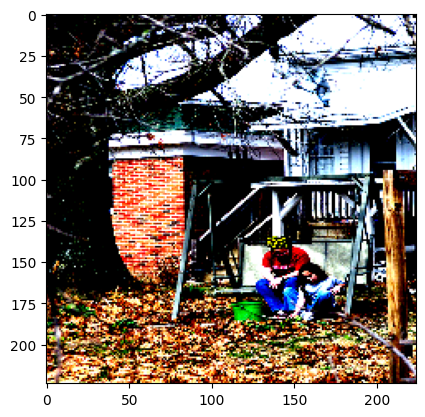

In [16]:
import matplotlib.pyplot as plt

train_dataset, val_dataset, test_dataset = get_datasets()

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
)
for item in train_dataloader:
    test_image =  item["image"][0].permute(1, 2, 0).cpu().numpy()
    print(item["caption"][0])
    plt.imshow(test_image)

    break
validation_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
)

#### Training

In [6]:
import itertools
import torch.nn.functional as F



model = CLIPModel()
model.to(DEVICE)
params = [
    {"params": model.image_encoder.parameters(), "lr": 1e-4},
    {"params": model.text_encoder.parameters(), "lr": 1e-5},
    {"params": itertools.chain(model.image_projection.parameters(
    ), model.text_projection.parameters()), "lr": 1e-3, "weight_decay": 1e-3},

]
optimizer = torch.optim.AdamW(params=params, weight_decay=0.0)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, mode="min", patience=1, factor=0.8
)
train_tqdm_object = tqdm(train_dataloader, total=len(train_dataloader))
for epoch in range(1):
    model.train()
    running_loss = 0.0
    for batch in train_tqdm_object:
        caption = batch.pop("caption")
        batch = {key: value.to(DEVICE) for key, value in batch.items()}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        break

    model.eval()
    with torch.no_grad():
        valid_loss_mean = compute_validation_loss(
            model, validation_dataloader)
    lr_scheduler.step(valid_loss_mean)

    epoch_loss = running_loss / len(train_dataloader)

    print(f"Epoch: {epoch}, Loss: {
            epoch_loss}, Valid Loss: {valid_loss_mean}")

  0%|          | 0/405 [00:00<?, ?it/s]/var/folders/vn/6bflx2h52yj49_wzhyq_90x40000gn/T/ipykernel_15484/1160739717.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(value[index]).clone().detach()
  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.0606527163658613, Valid Loss: 52.20391845703125


#### Inference

In [9]:
def get_image_embeddings(dataloader, model):
    # model = CLIPModel().to(DEVICE)
    # model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            image_features = model.image_encoder(batch["image"].to(DEVICE))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)


image_embeddings = get_image_embeddings(test_dataloader, model)


  0%|          | 0/51 [00:00<?, ?it/s]/var/folders/vn/6bflx2h52yj49_wzhyq_90x40000gn/T/ipykernel_15484/1160739717.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(value[index]).clone().detach()
100%|██████████| 51/51 [00:11<00:00,  4.44it/s]

torch.Size([1619, 512])


In [24]:
import matplotlib.pyplot as plt

def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(MODEL_CHECKPOINT)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(DEVICE)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(batch)
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    _, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image_filepath = "./archive/Images/"
        image = cv2.imread(f"{image_filepath}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

In [ ]:
find_matches(model,
             image_embeddings,
             query="a group of people dancing in a party",
             image_filenames=test_dataset.image_filenames,
             n=9)